Find a data set and build a KNN Regression and an OLS regression. Compare the two. How similar are they? Do they miss in different ways?

Create a Jupyter notebook with your models. At the end in a markdown cell write a few paragraphs to describe the models' behaviors and why you favor one model or the other. Try to determine whether there is a situation where you would change your mind, or whether one is unambiguously better than the other. Lastly, try to note what it is about the data that causes the better model to outperform the weaker model.

In [1]:
import numpy as np
import pandas as pd
import math
from matplotlib import pyplot as plt
from sklearn import linear_model
from sklearn import neighbors
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import cross_val_score
from sklearn import preprocessing
import seaborn as sns
%matplotlib inline
pd.options.display.float_format = '{:.3f}'.format

# Suppress annoying harmless error.
import warnings
warnings.filterwarnings(action="ignore", module="scipy", message="^internal gelsd")

## Prepping Data Set
I will be using a cereal data set, with the nutritional facts for 77 cereal brands. 
My outcome variable will be rating.

In [2]:
cereal = pd.read_csv('cereal.csv')

In [3]:
cereal.head()

,name,mfr,type,calories,protein,fat,sodium,fiber,carbo,sugars,potass,vitamins,shelf,weight,cups,rating
0,100% Bran,N,C,70,4,1,130,10.000,5.000,6,280,25,3,1.000,0.330,68.403
1,100% Natural Bran,Q,C,120,3,5,15,2.000,8.000,8,135,0,3,1.000,1.000,33.984
2,All-Bran,K,C,70,4,1,260,9.000,7.000,5,320,25,3,1.000,0.330,59.426
3,All-Bran with Extra Fiber,K,C,50,4,0,140,14.000,8.000,0,330,25,3,1.000,0.500,93.705
4,Almond Delight,R,C,110,2,2,200,1.000,14.000,8,-1,25,3,1.000,0.750,34.385


In [4]:
print(cereal.isnull().sum())
print('\n')
print(cereal.info())
print('\n')
print(cereal.describe())

name        0
mfr         0
type        0
calories    0
protein     0
fat         0
sodium      0
fiber       0
carbo       0
sugars      0
potass      0
vitamins    0
shelf       0
weight      0
cups        0
rating      0
dtype: int64


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 77 entries, 0 to 76
Data columns (total 16 columns):
name        77 non-null object
mfr         77 non-null object
type        77 non-null object
calories    77 non-null int64
protein     77 non-null int64
fat         77 non-null int64
sodium      77 non-null int64
fiber       77 non-null float64
carbo       77 non-null float64
sugars      77 non-null int64
potass      77 non-null int64
vitamins    77 non-null int64
shelf       77 non-null int64
weight      77 non-null float64
cups        77 non-null float64
rating      77 non-null float64
dtypes: float64(5), int64(8), object(3)
memory usage: 9.7+ KB
None


       calories  protein    fat  sodium  fiber  carbo  sugars  potass  \
count    77.000   77.00

In [5]:
#to see which variables are likely categorical, lets look at the unique value
for col in cereal.columns: 
    print('There are {} unique values for {}'.format((len(cereal[col].unique())),col))

There are 77 unique values for name
There are 7 unique values for mfr
There are 2 unique values for type
There are 11 unique values for calories
There are 6 unique values for protein
There are 5 unique values for fat
There are 27 unique values for sodium
There are 13 unique values for fiber
There are 22 unique values for carbo
There are 17 unique values for sugars
There are 36 unique values for potass
There are 3 unique values for vitamins
There are 3 unique values for shelf
There are 7 unique values for weight
There are 12 unique values for cups
There are 77 unique values for rating


In [34]:
#lets looks at correlations to help select the features I want to use
correlations = cereal.corr().loc[:,'rating'].abs().sort_values(ascending=False)
correlations

rating     1.000
sugars     0.760
calories   0.689
fiber      0.584
protein    0.471
fat        0.409
sodium     0.401
potass     0.380
weight     0.298
vitamins   0.241
cups       0.203
carbo      0.052
shelf      0.025
Name: rating, dtype: float64

OK, so after first inspection, I know that there are categorical variables in mfr, type, shelf, fat, vitamins, weight, and protein, that I will need to deal with. Not going to include shelf, weight or vitamins.

Note, I could treat these as continuous as well, for the cases where the variables could actually be ordinal.
However, I will continue with these choices. 

There are also negative values in carbo, sugars, and potassium that I will want to remove.



In [6]:
clean_cereal = cereal.copy()

In [7]:
#drop shelf, weight, vitamins
clean_cereal = clean_cereal.drop(['shelf','vitamins','weight'],axis=1)

#remove negative rows with negative values in carbo, sugars, or potass
clean_cereal = clean_cereal[clean_cereal.carbo != -1]
clean_cereal = clean_cereal[clean_cereal.sugars != -1]
clean_cereal = clean_cereal[clean_cereal.potass != -1]


In [8]:
clean_cereal.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 74 entries, 0 to 76
Data columns (total 13 columns):
name        74 non-null object
mfr         74 non-null object
type        74 non-null object
calories    74 non-null int64
protein     74 non-null int64
fat         74 non-null int64
sodium      74 non-null int64
fiber       74 non-null float64
carbo       74 non-null float64
sugars      74 non-null int64
potass      74 non-null int64
cups        74 non-null float64
rating      74 non-null float64
dtypes: float64(4), int64(6), object(3)
memory usage: 8.1+ KB


In [9]:
#need to convert our categorical vars of interest to object-

clean_cereal[['fat','protein']] = clean_cereal[['fat','protein']].astype(object)
clean_cereal.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 74 entries, 0 to 76
Data columns (total 13 columns):
name        74 non-null object
mfr         74 non-null object
type        74 non-null object
calories    74 non-null int64
protein     74 non-null object
fat         74 non-null object
sodium      74 non-null int64
fiber       74 non-null float64
carbo       74 non-null float64
sugars      74 non-null int64
potass      74 non-null int64
cups        74 non-null float64
rating      74 non-null float64
dtypes: float64(4), int64(4), object(5)
memory usage: 8.1+ KB


In [10]:
#categorical cleanup - making dummy variables for my categorical features
cereal_feat = pd.get_dummies(clean_cereal[['mfr','fat','protein']])

In [11]:
#before I add additional features to my feature data frame, 
#I awnt to look at the relationship with my continuous variables and rating

correlations = clean_cereal.corr().loc[:,'rating'].abs().sort_values(ascending=False)
correlations


rating     1.000
sugars     0.756
calories   0.694
fiber      0.603
potass     0.416
sodium     0.383
cups       0.223
carbo      0.056
Name: rating, dtype: float64

In [12]:
from IPython.display import display
correlation_matrix = clean_cereal.corr()
display(correlation_matrix)

,calories,sodium,fiber,carbo,sugars,potass,cups,rating
calories,1.000,0.296,-0.295,0.271,0.569,-0.071,0.089,-0.694
sodium,0.296,1.000,-0.071,0.328,0.037,-0.039,0.120,-0.383
fiber,-0.295,-0.071,1.000,-0.379,-0.151,0.912,-0.514,0.603
carbo,0.271,0.328,-0.379,1.000,-0.452,-0.365,0.358,0.056
sugars,0.569,0.037,-0.151,-0.452,1.000,0.001,-0.032,-0.756
potass,-0.071,-0.039,0.912,-0.365,0.001,1.000,-0.502,0.416
cups,0.089,0.120,-0.514,0.358,-0.032,-0.502,1.000,-0.223
rating,-0.694,-0.383,0.603,0.056,-0.756,0.416,-0.223,1.000


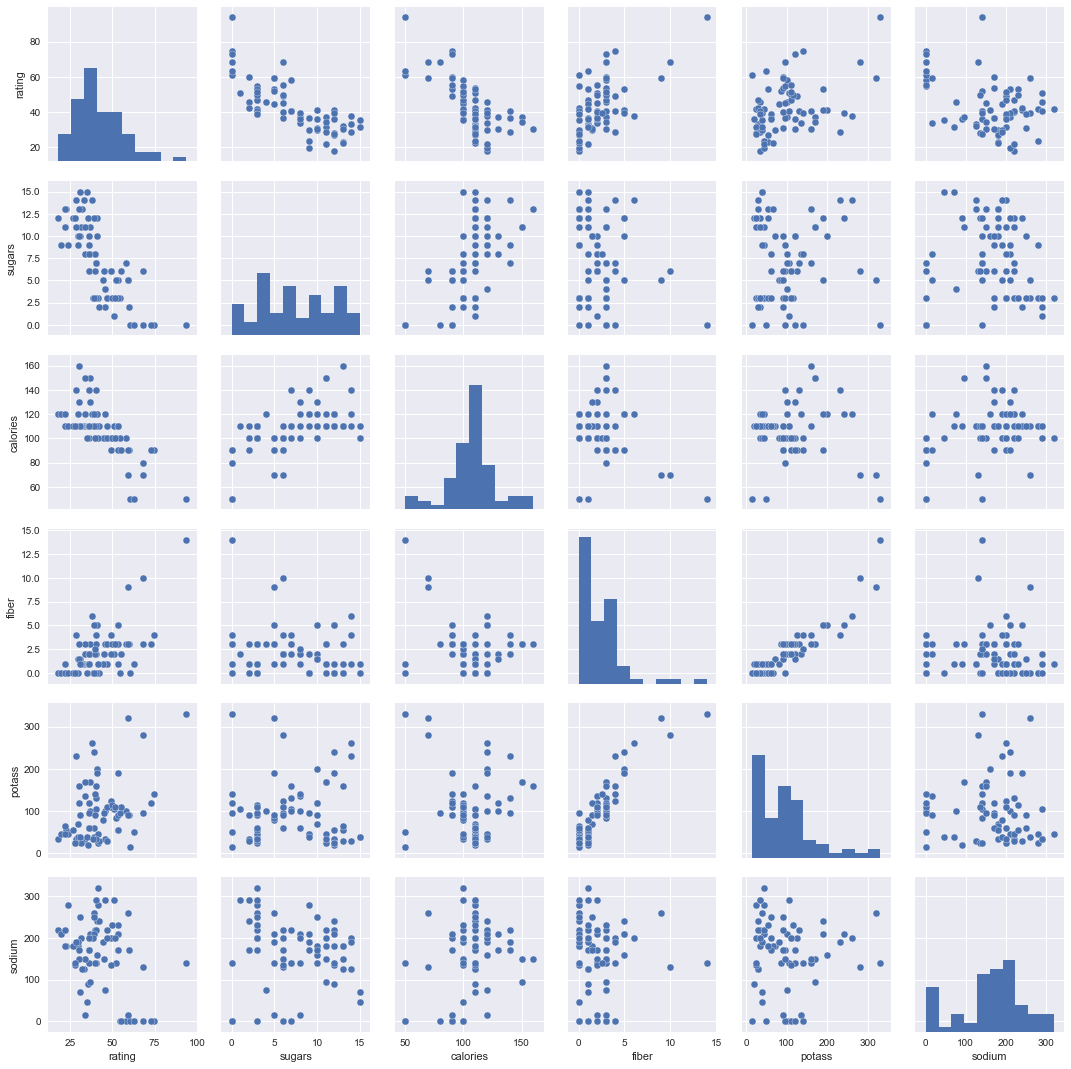

In [13]:
#going to create a pairplot to examine the relationships with rating
#excluding cups and carbo, as they  have low correlation with rating

clean_cereal = clean_cereal.drop(['cups','carbo'],axis=1)

sns.pairplot(clean_cereal[['rating','sugars','calories','fiber','potass','sodium']])

In [14]:
#I am going to drop sodium due to its lack of linnear relationship with ratings
#I also maybe want to consider combining fiber and potass as a new feature, due to their shared correltion.

means = clean_cereal[['potass','fiber']].mean(axis=0)
stds = clean_cereal[['potass','fiber']].std(axis=0)
cereal_feat['Pot_Fib'] = ((clean_cereal[['potass','fiber']]-means)/stds).mean(axis=1)


In [15]:
#now lets add sugar and calories to our feature data frame
cereal_feat['sugars'] = clean_cereal['sugars']
cereal_feat['calories'] = clean_cereal['calories']

In [16]:
cereal_feat.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 74 entries, 0 to 76
Data columns (total 20 columns):
mfr_A        74 non-null uint8
mfr_G        74 non-null uint8
mfr_K        74 non-null uint8
mfr_N        74 non-null uint8
mfr_P        74 non-null uint8
mfr_Q        74 non-null uint8
mfr_R        74 non-null uint8
fat_0        74 non-null uint8
fat_1        74 non-null uint8
fat_2        74 non-null uint8
fat_3        74 non-null uint8
fat_5        74 non-null uint8
protein_1    74 non-null uint8
protein_2    74 non-null uint8
protein_3    74 non-null uint8
protein_4    74 non-null uint8
protein_6    74 non-null uint8
Pot_Fib      74 non-null float64
sugars       74 non-null int64
calories     74 non-null int64
dtypes: float64(1), int64(2), uint8(17)
memory usage: 6.0 KB


In [17]:
#now scale!

# Select only numeric variables to scale.
df_num = cereal_feat.select_dtypes(include=[np.number]).dropna()

# Save the column names.
names=df_num.columns

# Scale, then turn the resulting numpy array back into a data frame with the correct column names.
cereal_scaled = pd.DataFrame(preprocessing.scale(df_num), columns=names, index=clean_cereal.index)



In [18]:
#select the best features

#for this, I will look at the corleation with the target var
#i need to add ratings to our data frame as well
cereal_scaled['rating'] = clean_cereal['rating']
corrmat = cereal_scaled.corr()
#top 10 features
print(corrmat.rating.abs().sort_values(ascending=False).iloc[1:11])

sugars      0.756
calories    0.694
Pot_Fib     0.521
mfr_N       0.508
fat_0       0.471
protein_1   0.427
mfr_G       0.368
protein_4   0.323
fat_2       0.219
fat_1       0.208
Name: rating, dtype: float64


## OLS REG

In [19]:
from sklearn import linear_model
regr = linear_model.LinearRegression()
features = cereal_scaled[['sugars', 'calories', 'Pot_Fib', 'mfr_N', 'fat_0', 'protein_1','mfr_G', 'protein_4',
                          'fat_2', 'fat_1']]
target = cereal_scaled['rating']

regr.fit(features,target)
print('\nCoefficients: \n', regr.coef_)
print('\nIntercept: \n', regr.intercept_)
print('\nR-squared:')
print(regr.score(features,target))



Coefficients: 
 [-6.01934354 -3.14164478  4.49185202  2.00958371  3.5879863  -1.94001013
 -1.20133545  1.12692254  0.80435241  1.27925419]

Intercept: 
 42.3717869324

R-squared:
0.930700718811


In [20]:
from sklearn.model_selection import train_test_split
from sklearn import model_selection

data_train, data_test, target_train, target_test = model_selection.train_test_split(
   features, target, test_size=0.30, random_state=42) 

# # Fit our model to the data.
regr.fit(data_train, target_train)

# Classify, storing the result in a new variable.
test_pred = regr.predict(data_test) 
train_pred = regr.predict(data_train)

print('\nTraining Coefficients: \n', regr.coef_)
print('\nTraining Intercept: \n', regr.intercept_)
print('\nTraining R-squared:')
print('The R^2 value for train set: {}',format(regr.score(data_train,target_train)))
print('The R^2 value for test set: {}',format(regr.score(data_test,target_test)))




Training Coefficients: 
 [-6.54371061 -3.1463199   4.88247862  2.79397807  2.72205779 -1.24707023
 -1.71650754  1.39083667  1.51434701  1.29778146]

Training Intercept: 
 42.3915068655

Training R-squared:
The R^2 value for train set: {} 0.9370912501128594
The R^2 value for test set: {} 0.846274011068691


The R^2 is fairly high. However, there could be some overfitting given the higher R^2 value in our train group. 
I could look into further modifying the features, but going to leave as is for now. 

I also want to look at the RMSE value as well as the predicted vs. residual values

In [163]:
from sklearn.model_selection import cross_val_predict
predict = cross_val_predict(regr, features, target, cv=5)
actual = target
RMSE = (np.mean((actual -predict)**2))**0.50
print(RMSE)

5.26666494185213


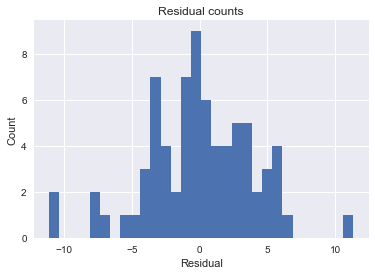

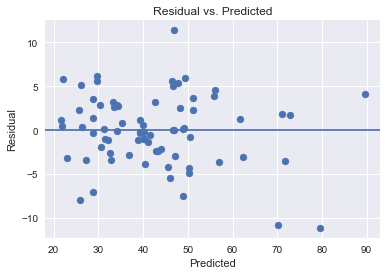

In [21]:
predicted = regr.predict(features)
actual = target


# Calculate residuals
residual = actual - predicted
residual = pd.to_numeric(residual)


# Histogram of residuals
plt.hist(residual,bins=30)
plt.title('Residual counts')
plt.xlabel('Residual')
plt.ylabel('Count')
plt.xlim()
plt.show()

plt.scatter(predicted, residual)
plt.xlabel('Predicted')
plt.ylabel('Residual')
plt.axhline(y=0)
plt.title('Residual vs. Predicted')
plt.show()



Not terrible. High R^2 and the RMSE is relatively low.

## KNN REG

In [23]:


from sklearn.preprocessing import MinMaxScaler
from sklearn import neighbors
scaler = MinMaxScaler()

# using the features from my lin reg
knn = neighbors.KNeighborsRegressor(n_neighbors=5)
X = pd.DataFrame(cereal_feat[['sugars', 'calories', 'Pot_Fib', 'mfr_N', 'fat_0', 'protein_1','mfr_G', 'protein_4',
                          'fat_2', 'fat_1']])
X_norm = scaler.fit_transform(X)
Y = clean_cereal.rating
knn.fit(X_norm, Y)

from sklearn.model_selection import cross_val_score
score = cross_val_score(knn, X_norm, Y, cv=5)
print('\nEach Cross Validated R2 score: \n', score)
print("\nUnweighted Accuracy: %0.2f (+/- %0.2f)" % (score.mean(), score.std() * 2))



Each Cross Validated R2 score: 
 [ 0.52937795  0.54370826  0.40479135  0.21807929  0.35222527]

Unweighted Accuracy: 0.41 (+/- 0.24)


In [24]:
#this isn't great, so now I am going to look at the features from the OLS model that have highest corr with rating
from sklearn.preprocessing import MinMaxScaler
from sklearn import neighbors
scaler = MinMaxScaler()


knn = neighbors.KNeighborsRegressor(n_neighbors=5)
X = pd.DataFrame(cereal_feat[[ 'sugars', 'calories', 'Pot_Fib']
])
X_norm = scaler.fit_transform(X)
Y = clean_cereal.rating
knn.fit(X_norm, Y)

from sklearn.model_selection import cross_val_score
score = cross_val_score(knn, X_norm, Y, cv=5)
print('\nEach Cross Validated R2 score: \n', score)
print("\nUnweighted Accuracy: %0.2f (+/- %0.2f)" % (score.mean(), score.std() * 2))



Each Cross Validated R2 score: 
 [ 0.742222    0.51209123  0.81242877  0.87602278  0.55019042]

Unweighted Accuracy: 0.70 (+/- 0.29)


In [25]:
#this is much better, but still not has good as the OLS model 
#lets try weighting my neighbors Extract predicted values.
#weighted
knn_w = neighbors.KNeighborsRegressor(n_neighbors=5, weights='distance')
knn_w.fit(X_norm, Y)

score_w = cross_val_score(knn_w, X_norm, Y, cv=5)
print('\nEach Cross Validated R2 score: \n', score_w)
print("\nUnweighted Accuracy: %0.2f (+/- %0.2f)" % (score_w.mean(), score_w.std() * 2))


Each Cross Validated R2 score: 
 [ 0.74038143  0.53904589  0.80362764  0.81206763  0.57055427]

Unweighted Accuracy: 0.69 (+/- 0.23)


This is about the same as the unweighted model. Now let's look at the RMSE

In [29]:
from sklearn.model_selection import cross_val_predict
predict_k = cross_val_predict(knn, X_norm, Y, cv=5)

actual_k = Y
RMSE = (np.mean((actual_k -predict_k)**2))**0.50
print(RMSE)



7.352982174259503


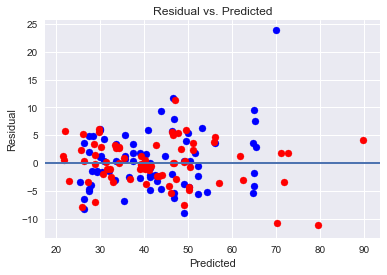

In [30]:
#OLS
predicted = regr.predict(features)
actual = target


# KNN
predicted_k = knn.predict(X_norm)
actual_k = Y

# Calculate residuals
residual = actual - predicted
residual = pd.to_numeric(residual)

residual_k = actual_k - predicted_k
residual_k = pd.to_numeric(residual_k)

plt.scatter(predicted_k, residual_k, c='b')
plt.xlabel('Predicted')
plt.ylabel('Residual')
plt.axhline(y=0)
plt.title('Residual vs. Predicted')


plt.scatter(predicted, residual,c='r')
plt.xlabel('Predicted')
plt.ylabel('Residual')
plt.axhline(y=0)
plt.title('Residual vs. Predicted')
plt.show()


This is interesting. The points are pretty close together, but the range of the predicted values for OLS is higher. 
This is because the largest value the nearest neighbor model can predict has to be the largest value in the training set, which needs to be the nbearest neighbor. With the KNN model, we are taking weighted averages, which are never going to return the max predicted value. 

Overall, my OLS model did better, but there is some tuning I can do to both, overall. 